# Setup

In [1]:
# Janky code to do different setup when run in a Colab notebook vs VSCode
DEVELOPMENT_MODE = False
try:
    import google.colab
    IN_COLAB = True
    print("Running as a Colab notebook")
    %pip install git+https://github.com/neelnanda-io/TransformerLens.git
    %pip install circuitsvis

    # PySvelte is an unmaintained visualization library, use it as a backup if circuitsvis isn't working
    # # Install another version of node that makes PySvelte work way faster
    # !curl -fsSL https://deb.nodesource.com/setup_16.x | sudo -E bash -; sudo apt-get install -y nodejs
    # %pip install git+https://github.com/neelnanda-io/PySvelte.git
    !wget https://raw.githubusercontent.com/sebastianGehrmann/CausalMediationAnalysis/master/experiment_data/professions_male_stereo.json
    !wget https://raw.githubusercontent.com/sebastianGehrmann/CausalMediationAnalysis/master/experiment_data/professions_female_stereo.json
    !wget https://raw.githubusercontent.com/elidub/GenderBiasCircuit/main/data/toys_boys.txt
    !wget https://raw.githubusercontent.com/elidub/GenderBiasCircuit/main/data/toys_girls.txt
except:
    IN_COLAB = False
    print("Running as a Jupyter notebook - intended for development only!")
    from IPython import get_ipython

    ipython = get_ipython()
    # Code to automatically update the HookedTransformer code as its edited without restarting the kernel
    ipython.magic("load_ext autoreload")
    ipython.magic("autoreload 2")

Running as a Colab notebook
  Cloning https://github.com/neelnanda-io/TransformerLens.git to /tmp/pip-req-build-c79oeceg
  Running command git clone --filter=blob:none --quiet https://github.com/neelnanda-io/TransformerLens.git /tmp/pip-req-build-c79oeceg
  Resolved https://github.com/neelnanda-io/TransformerLens.git to commit 3cd943628b5c415585c8ef100f65989f6adc7f75
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 30.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 80.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 69.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 26.3 MB/s eta 0:00:00
--2023-06-27 21:34:18--  https://raw.githubusercontent.com/sebastianGehrmann/CausalMediationAnalysis/master/experiment_data/professions_male_stereo.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5742 (5.6K) [text/plain]
Saving to: ‘professions_male_stereo.json’

professions_male_st 100%[===================>]   5.61K  --.-KB/s    in 0s      

2023-06-27 21:34:18 (42.3 MB/s) - ‘professions_male_stereo.json’ saved [5742/5742]

--2023-06-27 21:34:18--  https://raw.githubusercontent.com/sebastianGehrmann/CausalMediationAnalysis/master/experiment_data/professions_female_stereo.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133,

In [2]:
# Plotly needs a different renderer for VSCode/Notebooks vs Colab argh
import plotly.io as pio
if IN_COLAB or not DEVELOPMENT_MODE:
    pio.renderers.default = "colab"
else:
    pio.renderers.default = "notebook_connected"
print(f"Using renderer: {pio.renderers.default}")

Using renderer: colab


In [13]:
import circuitsvis as cv
# Testing that the library works
cv.examples.hello("world")

# Import stuff
import torch
import numpy as np
import einops
from fancy_einsum import einsum
import tqdm.auto as tqdm
import random
from pathlib import Path
import matplotlib.pyplot as plt
import plotly.express as px
from torch.utils.data import DataLoader
from typing import Literal
import pandas as pd

from jaxtyping import Float, Int
from typing import List, Union, Optional, Tuple
from functools import partial
import json


import itertools
from transformers import AutoModelForCausalLM, AutoConfig, AutoTokenizer
import dataclasses
import datasets
from IPython.display import HTML

In [4]:
import transformer_lens
import transformer_lens.utils as utils
from transformer_lens.hook_points import (
    HookedRootModule,
    HookPoint,
)  # Hooking utilities
from transformer_lens import HookedTransformer, HookedTransformerConfig, FactoredMatrix, ActivationCache

In [5]:
from typing import List, Tuple, Dict, Union, Optional, Callable, Any
from time import ctime
import einops
import torch
import numpy as np
from copy import deepcopy
from collections import OrderedDict
import pickle
from subprocess import call
from IPython import get_ipython

ipython = get_ipython()
if ipython is not None:
    ipython.magic("load_ext autoreload")
    ipython.magic("autoreload 2")

In [6]:
def imshow(tensor, renderer=None, xaxis="", yaxis="", **kwargs):
    px.imshow(utils.to_numpy(tensor), color_continuous_midpoint=0.0, color_continuous_scale="RdBu", labels={"x":xaxis, "y":yaxis}, **kwargs).show(renderer)

def line(tensor, renderer=None, xaxis="", yaxis="", **kwargs):
    px.line(utils.to_numpy(tensor), labels={"x":xaxis, "y":yaxis}, **kwargs).show(renderer)

def scatter(x, y, xaxis="", yaxis="", caxis="", renderer=None, **kwargs):
    x = utils.to_numpy(x)
    y = utils.to_numpy(y)
    px.scatter(y=y, x=x, labels={"x":xaxis, "y":yaxis, "color":caxis}, **kwargs).show(renderer)

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
if not torch.cuda.is_available():
    print("WARNING: Running on CPU. Did you remember to set your Colab accelerator to GPU?")
torch.set_grad_enabled(False)

# Download data and model

In [8]:
model_name = 'gpt2-small'
model = HookedTransformer.from_pretrained(model_name, device=device)
model.cfg.use_attn_result = True

Using pad_token, but it is not set yet.


Loaded pretrained model gpt2-small into HookedTransformer


In [9]:
def get_dataset(name="professions_she_he"):
    allowed_names = [
        "professions_she_he",
        "professions_woman_man",
        "toys_she_he",
        "grammatical_she_he",
    ]
    assert name in allowed_names, f"Dataset {name} is not implemented"

    if name == "professions_she_he":
        # We're going to load up some examples.
        with open("professions_female_stereo.json", 'r') as f:
            female_stereo_professions = [x[0] for x in json.load(f)]

        with open("professions_male_stereo.json", 'r') as f:
            male_stereo_professions = [x[0] for x in json.load(f)]

        # ensure that they're single tokens
        female_stereo_professions_lens = [len(model.tokenizer.encode(f' {x}')) for x in female_stereo_professions]
        female_stereo_professions = [x for x, l in zip(female_stereo_professions, female_stereo_professions_lens) if l == 1]

        male_stereo_professions_lens = [len(model.tokenizer.encode(f' {x}')) for x in male_stereo_professions]
        male_stereo_professions = [x for x, l in zip(male_stereo_professions, male_stereo_professions_lens) if l == 1]

        # slot them into our sentences
        female_stereo_sentences = [f"The {profession} said that" for profession in female_stereo_professions]
        male_stereo_sentences = [f"The {profession} said that" for profession in male_stereo_professions]

        female_word = "she"
        male_word = "he"

    elif name == "professions_woman_man":
        # We're going to load up some examples.
        with open("professions_female_stereo.json", 'r') as f:
            female_stereo_professions = [x[0] for x in json.load(f)]

        with open("professions_male_stereo.json", 'r') as f:
            male_stereo_professions = [x[0] for x in json.load(f)]

        # ensure that they're single tokens
        female_stereo_professions_lens = [len(model.tokenizer.encode(f' {x}')) for x in female_stereo_professions]
        female_stereo_professions = [x for x, l in zip(female_stereo_professions, female_stereo_professions_lens) if l == 1]

        male_stereo_professions_lens = [len(model.tokenizer.encode(f' {x}')) for x in male_stereo_professions]
        male_stereo_professions = [x for x, l in zip(male_stereo_professions, male_stereo_professions_lens) if l == 1]

        # slot them into our sentences
        female_stereo_sentences = [f"The {profession} identifies as a" for profession in female_stereo_professions]
        male_stereo_sentences = [f"The {profession} identifies as a" for profession in male_stereo_professions]

        female_word = "woman"
        male_word = "man"

    elif name == "toys_she_he":
      # We're going to load up some examples.
      with open("toys_girls.txt", 'r') as f:
          toys_girls = [x.strip() for x in f.readlines()]

      with open("toys_boys.txt", 'r') as f:
          toys_boys = [x.strip() for x in f.readlines()]

      # ensure that they're single tokens
      toys_girls_lens = [len(model.tokenizer.encode(f' {x}')) for x in toys_girls]
      toys_girls = [x for x, l in zip(toys_girls, toys_girls_lens) if l == 1]

      toys_boys_lens = [len(model.tokenizer.encode(f' {x}')) for x in toys_boys]
      toys_boys = [x for x, l in zip(toys_boys, toys_boys_lens) if l == 1]

      # slot them into our sentences
      female_stereo_sentences = [f'The kid received {toy}, it was the best day of' for toy in toys_girls]
      male_stereo_sentences = [f'The kid received {toy}, it was the best day of' for toy in toys_boys]

      female_word = "her"
      male_word = "his"

    elif name == "grammatical_she_he":
        # Adapted from https://arxiv.org/abs/2004.12265
        templates = [
            "The {noun} said that",
            "The {noun} yelled that",
            "The {noun} whispered that",
            "The {noun} wanted that",
            "The {noun} desired that",
            "The {noun} wished that",
            "The {noun} ate because",
            "The {noun} ran because",
            "The {noun} drove because",
            "The {noun} slept because",
            "The {noun} cried because",
            "The {noun} laughed because",
            "The {noun} went home because",
            "The {noun} stayed up because",
            "The {noun} was fired because",
            "The {noun} was promoted because",
            "The {noun} yelled because because"
            ]

        female_stereo_sentences = [sentence.format(noun="woman") for sentence in templates]
        male_stereo_sentences = [sentence.format(noun="man") for sentence in templates]

        female_word = "she"
        male_word = "he"

    # convert our sentences into tokens
    female_stereo_toks = model.to_tokens(female_stereo_sentences)
    male_stereo_toks = model.to_tokens(male_stereo_sentences)

    return (female_stereo_toks, male_stereo_toks), (female_stereo_sentences, male_stereo_sentences), (female_word, male_word)

# A Structured Approach to Mechanistic Interpretability via Circuits

In [21]:
def get_bottom_k_indices(arr, k):
    # Ensure arr is a numpy array
    if type(arr) != np.ndarray:
        arr = np.array(arr)

    # Flatten the array and get the indices of the smallest k elements
    flat_indices = np.argpartition(arr.flatten(), k)[:k]

    # Convert the flat indices to 2D indices
    indices = layer, head_mlp = np.unravel_index(flat_indices, arr.shape)

    # Zip the indices together into tuples
    indices = list(zip(indices[0], indices[1]))
    sorted_indices = sorted(indices, key=lambda x: arr[x[0]][x[1]])

    # Return the sorted indices
    return [i if i[1] != 12 else (i[0], 'mlp') for i in sorted_indices]

def get_prob_change(female_toks, male_toks, female_word, male_word, circuit = None):

    she_token = model.tokenizer.encode(f' {female_word}')[0]
    he_token = model.tokenizer.encode(f' {male_word}')[0]

    original_probs = torch.softmax(model(female_toks, return_type="logits")[:, -1], dim=-1).mean(0)
    orig_prob_diff = original_probs[she_token] - original_probs[he_token]

    sampling_indices = torch.randint(0, male_toks.size(0), (female_toks.size(0),))
    orig_logits, original_cache = model.run_with_cache(female_toks)
    ablated_logits, ablated_cache = model.run_with_cache(male_toks[sampling_indices])

    def make_final_residual_stream_hook(original_value: torch.Tensor, new_value: torch.Tensor):
        def final_residual_stream_hook(value: Float[torch.Tensor, "batch pos d_residual"], hook: HookPoint):
            value[:, -1, :] = value[:, -1, :] - original_value[:, -1, :] + new_value[:, -1, :]
            return value
        return final_residual_stream_hook


    def direct_ablation(layer: int, head_or_mlp: Union[Literal['mlp'], int]) -> torch.Tensor:

        def get_output_from_cache(cache: ActivationCache, layer:int, head_or_mlp: Union[int, Literal['mlp']]) -> torch.Tensor:
            if head_or_mlp == 'logits':
                raise ValueError("Just use the actual logits")
            elif head_or_mlp == 'mlp':
                return cache[f'blocks.{layer}.hook_mlp_out']
            else:
                return cache[f'blocks.{layer}.attn.hook_result'][:, :, head_or_mlp]


        if head_or_mlp == 'mlp':
            hook = f"blocks.{layer}.hook_mlp_out"
        else:
            hook = f"blocks.{layer}.attn.hook_result"

        A_original = get_output_from_cache(original_cache, layer, head_or_mlp)
        A_ablation =  get_output_from_cache(ablated_cache, layer, head_or_mlp)

        final_hook = make_final_residual_stream_hook(A_original, A_ablation)

        direct_logits = model.run_with_hooks(
            female_toks,
            return_type="logits",
            fwd_hooks=[(
                'blocks.11.hook_resid_post',
                final_hook
                )]
        )
        return direct_logits


    prob_diffs = []
    for layer in range(12):
        for head_or_mlp in [*range(12), 'mlp']:
            direct_logits = direct_ablation(layer, head_or_mlp)
            direct_probs = torch.softmax(direct_logits, dim=-1).mean(0)[-1]
            prob_diff = direct_probs[she_token] - direct_probs[he_token]
            prob_diffs.append(prob_diff)
    prob_diffs = torch.tensor(prob_diffs).to(device)
    prob_change = prob_diffs - orig_prob_diff.unsqueeze(0)
    prob_change = prob_change.view(12, 13)

    prob_change = np.array(prob_change.cpu())


    def get_output_from_cache(cache: ActivationCache, layer:int, head_or_mlp: Union[int, Literal['mlp']]) -> torch.Tensor:
        if head_or_mlp == 'logits':
            raise ValueError("Just use the actual logits")
        elif head_or_mlp == 'mlp':
            return cache[f'blocks.{layer}.hook_mlp_out']
        else:
            return cache[f'blocks.{layer}.attn.hook_result'][:, :, head_or_mlp]

    # circuit = [(10, 9), (9, 7), (11, 8), (10, 'mlp'), (9, 'mlp'), (9, 2), (8, 11), (8, 'mlp'), (4,3), (6,0)]
    circuit = get_bottom_k_indices(prob_change, 10) if circuit is None else circuit

    original_values = torch.sum(torch.stack([get_output_from_cache(ablated_cache, *component) for component in circuit]), dim=0)
    new_values = torch.sum(torch.stack([get_output_from_cache(original_cache, *component) for component in circuit]), dim=0)

    circuit_logits = model.run_with_hooks(
            male_toks[sampling_indices],
            return_type="logits",
            fwd_hooks=[(
                "blocks.11.hook_resid_post",
                make_final_residual_stream_hook(original_values, new_values)
                )]
            )
    diffs = {}
    for name, logits in zip(['original prob diff', 'ablated prob diff', 'circuit prob diff'], [orig_logits, ablated_logits, circuit_logits]):
        probs = torch.softmax(logits, dim=-1).mean(0)[-1]
        prob_diff = probs[she_token] - probs[he_token]
        print(f'{name}: {prob_diff:0.3f}')
        diffs[name] = prob_diff.item()

    return prob_change, diffs, circuit

""" how much she over he?
original prob diff -> if we don't change anything, female professions,
ablated prob diff  -> look at male professions. Should be negative
circuit prob diff  -> only the circuit components.    Should be positive and higher than original prob diff
circuit prob diff  -> take male tokens, replace

Rewrite by K:
prob diff ~ how many % more likely the model predicts a female token rather than a male token
original prob diff -> prob diff on female stereotypes (is expected to be positive if the model picks up on the stereotype)
ablated prob diff  -> prob diff on male stereotypes   (is expected to be negative if the model picks up on the stereotype)
circuit prob diff  -> prob diff when the circuit gets female stereotypes and the rest of the network gets male stereotypes (is expected to be positive if the circuit is responsible for favoring the stereotypical token)

It follows:
=> (original + ablated) -> how much more does the model favor female tokens regardless of stereotype? (a priori, usually negative because training data is biased towards males)
=> (original - ablated) -> how much more does the model favor female tokens when provided a female stereotype instead of a male stereotype? <=> how much can the input make the entire model favor female token?
=> (circuit - ablated) -> how much does fooling the circuit to act "female" make the model favor female tokens, with otherwise male input?
=> if circuit prob diff is close to original prob diff -> the circuit is responsible for deciding between male and female token
  <=> This one I'm not sure, need to think about it more: (circuit - ablated) / (original - ablated) is a measure of how much the circuit (rather than the input) is responsible for producing the stereotype
=> if circuit prob diff is close to ablated  prob diff -> the circuit is NOT responsible for deciding between male and female token

Now what if we evaluate circuit_X on dataset Y?
circuit_X prob diff_Y ->
"""

"""
top
---
circuit
original
ablated
---
bottom
"""

dataset_names = [
    "professions_she_he",
    "professions_woman_man",
    "toys_she_he",
    "grammatical_she_he",
]

data = {}


for dataset_name in dataset_names:
  print("Working on dataset ", dataset_name)
  (female_stereo_toks, male_stereo_toks), (female_stereo_sentences, male_stereo_sentences), (female_word, male_word) = get_dataset(dataset_name)

  prob_change, diffs, circuit = get_prob_change(female_toks = female_stereo_toks, male_toks = male_stereo_toks, female_word = female_word, male_word = male_word)

  data[dataset_name] = {'prob_change' : prob_change, 'diffs' : diffs, 'circuit' : circuit}

  fig = px.imshow(prob_change, color_continuous_scale='RdBu', zmin=-0.06, zmax=0.06, labels={'x':'head or mlp', 'y':'layer', 'color':'prob diff change'}, y=list(range(12)), x=[*(str(i) for i in range(12)), 'mlp'], width=800, height=600, title=f'Prob Diff Change by Layer / Head, dataset: {dataset_name}')
  fig.show()

Working on dataset  professions_she_he
original prob diff: 0.020
ablated prob diff: -0.086
circuit prob diff: 0.037


Working on dataset  professions_woman_man
original prob diff: 0.024
ablated prob diff: 0.005
circuit prob diff: 0.054


Working on dataset  toys_she_he
original prob diff: -0.400
ablated prob diff: -0.544
circuit prob diff: -0.410


Working on dataset  grammatical_she_he
original prob diff: 0.159
ablated prob diff: -0.088
circuit prob diff: 0.105


In [27]:
df = pd.DataFrame({dataset_name: d['diffs'] for dataset_name, d in data.items()}).T
df

,original prob diff,ablated prob diff,circuit prob diff
professions_she_he,0.019538,-0.085724,0.037051
professions_woman_man,0.023697,0.005478,0.054421
toys_she_he,-0.399843,-0.544242,-0.410326
grammatical_she_he,0.158563,-0.087792,0.104753


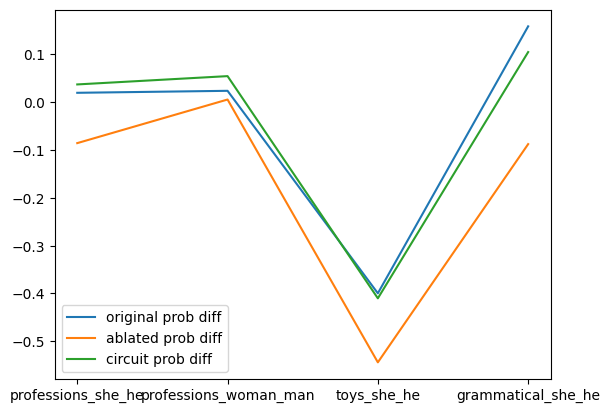

In [32]:
plt.plot(df)
plt.legend(df.columns)
plt.show()


```
original prob diff -> if we don't change anything, female professions,
ablated prob diff  -> look at male professions. Should be negative
circuit prob diff  -> only the circuit components.    Should be positive and higher than original prob diff
```

